In [ ]:
# make pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable as Var

# make relevant imports
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# define a general NN

class NN(nn.Module):

  def __init__(self, inp=3, outp=3):
    super(NN, self).__init__()
    self.fc1 = nn.Linear(inp, 20) # fully connected layers
    self.fc2 = nn.Linear(20, 20)
    self.fc3 = nn.Linear(20, 20)
    self.fc4 = nn.Linear(20, 20)
    self.fc5 = nn.Linear(20, outp)

  def forward(self, x):
    if x.requires_grad==False:
      x.requires_grad==True  # keep track of gradient wrt input

    y = torch.tanh(self.fc1(x))
    y = torch.tanh(self.fc2(y))
    y = torch.tanh(self.fc3(y))
    y = torch.tanh(self.fc4(y))
    y = (self.fc5(y))

    return y

In [ ]:
# Define Neural Networks

encoder = NN(inp=3, outp=3)    # maps original coordinates to encoding
decoder = NN(inp=3, outp=3)    # maps encoding back to original coordinates
estimator = NN(inp=1, outp=3)  # estimates the target functions

In [ ]:
# read in data with pandas
# convert to numpy and torch tensors

#xls = pd.ExcelFile('Subystems_Data_For_George.xlsx')
data = pd.read_csv('Subsystem1_Data_for_George.csv')

# use only first three functions
f1data = data['t1'].to_numpy()
f2data = data['t2'].to_numpy()
f3data = data['t3'].to_numpy()

print(len(f1data))

f_target = np.zeros([len(f1data), 3])
f_target[:, 0] = f1data
f_target[:, 1] = f2data
f_target[:, 2] = f3data

k1f = data['k1f'].to_numpy()
k1r = data['k1r'].to_numpy()
kcat1 = data['kcat1'].to_numpy()

k_parameters = np.zeros([len(k1f),3])
k_parameters[:, 0] = k1f
k_parameters[:, 1] = k1r
k_parameters[:, 2] = kcat1

# normalize
k_parameters = (k_parameters - np.mean(k_parameters, axis=0))/np.std(k_parameters, axis=0)
f_target = (f_target - np.mean(f_target, axis=0))/np.std(f_target, axis=0)

3000


In [ ]:
# define loss criterion and NN Vars:
criterion = nn.MSELoss(reduction='mean')
criterion2 = nn.L1Loss()

k_params_in = Var(torch.from_numpy(k_parameters))
k_params_in.requires_grad=True

print(k_params_in)


f_target_out = Var(torch.from_numpy(f_target))
reg_target = torch.zeros(len(f_target))

# set optimizers
optimizer1 = optim.Adam(encoder.parameters(), lr=0.00001)
optimizer2 = optim.Adam(decoder.parameters(), lr=0.0001)
optimizer3 = optim.Adam(estimator.parameters(), lr=0.0001)

tensor([[-0.2930,  0.7883, -1.7105],
        [-0.6893, -1.2190, -1.3913],
        [-1.0902, -0.5235, -0.3371],
        ...,
        [ 0.8379, -0.4231,  0.1859],
        [-1.2583,  0.2807,  0.2820],
        [ 0.2818,  1.4884,  0.1350]], dtype=torch.float64, requires_grad=True)


In [ ]:
###########################################################
# Training All three networks
###########################################################

encoder.train()
decoder.train()
estimator.train()

encoder.double()
decoder.double()
estimator.double()

for time in range(10000):
  encoding_pred = encoder(k_params_in)  # make prediction
  k_params_pred = decoder(encoding_pred)

  dj1_dk = autograd.grad(encoding_pred[:,0], k_params_in, torch.ones(encoding_pred[:,0].size()), retain_graph=True, allow_unused=True, create_graph=True)[0]
  dj2_dk = autograd.grad(encoding_pred[:,1], k_params_in, torch.ones(encoding_pred[:,0].size()), retain_graph=True, allow_unused=True, create_graph=True)[0]
  dj3_dk = autograd.grad(encoding_pred[:,2], k_params_in, torch.ones(encoding_pred[:,0].size()), retain_graph=True, allow_unused=True, create_graph=True)[0]

  reg1 = torch.mul(dj1_dk, dj2_dk).sum(1)
  reg2 = torch.mul(dj1_dk, dj3_dk).sum(1)
  reg3 = torch.mul(dj2_dk, dj3_dk).sum(1)

  loss1 = criterion(k_params_pred, k_params_in) # compute loss
  loss1 += 33 * criterion2(reg1.double(), reg_target.double())
  
  loss1 += 33 * criterion2(reg2.double(), reg_target.double())
  loss1 += 33 * criterion2(reg3.double(), reg_target.double())

  # backward pass and update
  optimizer1.zero_grad()
  optimizer2.zero_grad()
  loss1.backward(retain_graph=True)
  optimizer1.step()
  optimizer2.step()

  encoding_pred = encoder(k_params_in)
  f_pred = estimator(torch.unsqueeze(encoding_pred[:, 0], dim=1))

  loss2 = criterion(f_pred, f_target_out)

  optimizer3.zero_grad()
  optimizer1.zero_grad()
  loss2.backward()
  optimizer3.step()
  optimizer1.step()
  # if criterion(k_params_pred, k_params_in).item() < 0.0001:
  #     break

  if time%50 == 0:
    print('Epoch: {}, Loss1: {}, Regularity: {}, Loss2: {}'.format(time, loss1.item(), criterion(reg1+reg2+reg3, reg_target), loss2.item()))
    

Epoch: 0, Loss1: 0.000381636286331688, Regularity: 2.244604770327163e-11, Loss2: 2.8380409780861796e-05
Epoch: 50, Loss1: 0.00031031134753728814, Regularity: 1.9914731131190628e-11, Loss2: 1.9653854700908426e-05
Epoch: 100, Loss1: 0.00030758945876292363, Regularity: 1.978438141041779e-11, Loss2: 1.956694477252062e-05
Epoch: 150, Loss1: 0.00030551203951813586, Regularity: 1.9668278397426185e-11, Loss2: 1.951496292857856e-05
Epoch: 200, Loss1: 0.0003031673208651928, Regularity: 1.952567449372515e-11, Loss2: 1.9453019201005967e-05
Epoch: 250, Loss1: 0.0003006189006132511, Regularity: 1.936841194606679e-11, Loss2: 1.938086000305352e-05
Epoch: 300, Loss1: 0.000297904836344347, Regularity: 1.9186144257267382e-11, Loss2: 1.9306401869294902e-05
Epoch: 350, Loss1: 0.00029503675931253503, Regularity: 1.898399104122994e-11, Loss2: 1.9231518018827553e-05
Epoch: 400, Loss1: 0.00029206689841306275, Regularity: 1.8771826633344036e-11, Loss2: 1.9156494788301928e-05
Epoch: 450, Loss1: 0.000289144977346

KeyboardInterrupt: ignored

In [ ]:
# print(criterion(k_params_pred, k_params_in).item())

encoder.eval()
decoder.eval()
estimator.eval()

torch.save(encoder, 'encoder1_good')
torch.save(decoder, 'decoder1_good')
torch.save(estimator, 'estimator1_good')

# New Section

In [ ]:
encoder = torch.load('encoder1_good')
decoder = torch.load('decoder1_good')
estimator = torch.load('estimator1_good')

In [ ]:
pred = encoder(k_params_in.float())
f_pred = decoder(pred)

RuntimeError: ignored

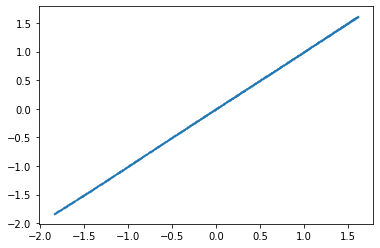

In [ ]:
# Some of the cells below won't run if you haven't trained the networks on here. After loading, you need to run on the data 
# (k_params_in) and then plot.
plt.scatter(f_target_out[:,0].data.numpy(),f_pred[:, 0].data.numpy(),s=0.1)
# plt.scatter(f_target_out[:,1].data.numpy(),f_pred[:, 1].data.numpy(),s=0.1)
# plt.scatter(f_target_out[:,2].data.numpy(),f_pred[:, 2].data.numpy(),s=0.1)

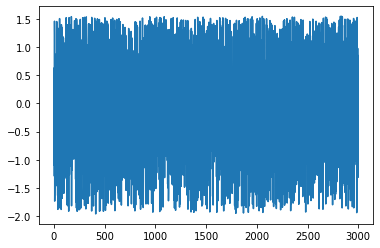

In [ ]:
plt.plot(f_pred[:, 2].data.numpy())

ValueError: ignored

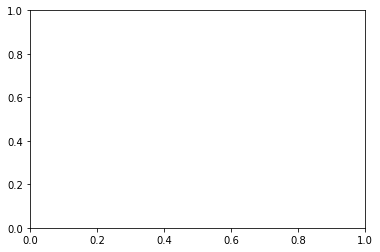

In [ ]:
plt.scatter(pred[:, 2].data, k1f)

In [ ]:
pred = encoder(k_params_in.float())

RuntimeError: ignored

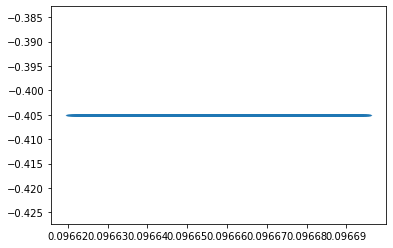

In [ ]:
plt.scatter(pred.data[:,0],k1f, s=0.1)

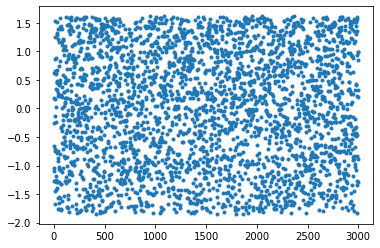

In [ ]:
plt.plot(f_target_out[:,0],".")

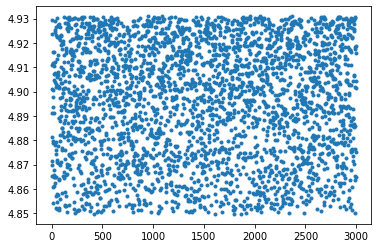

In [ ]:
plt.plot(f3data,".")

In [ ]:
###################################################
# Plot Level Sets
###################################################

print(max(k_parameters[0]))
print(max(k_parameters[1]))
print(max(k_parameters[1]))

print(min(k_parameters[0]))
print(min(k_parameters[1]))
print(min(k_parameters[2]))


# Since the data is a cube, fix the first and take the range over the second and third
k1f = k_parameters[0].mean()*np.ones(40000)
k1r = np.linspace(min(k_parameters[1]),max(k_parameters[1]),1000)
kcat = np.linspace(min(k_parameters[2]),max(k_parameters[2]),1000)


0.7882655852143134
-0.6892773634139235
-0.6892773634139235
-1.710452396270835
-1.3913339973378462
-1.0901624341735587


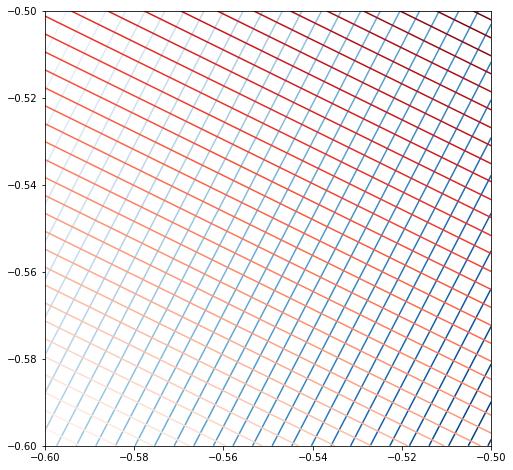

In [ ]:
#xx, yy = np.mgrid[min(k_parameters[1])/2:max(k_parameters[1])/2:200j, min(k_parameters[2])/2:max(k_parameters[2])/2:200j]
xx, yy = np.mgrid[-0.5:-0.6:200j, -0.5:-0.6:200j]

cartesian_points = np.vstack([k1f.flatten(), xx.flatten(),yy.flatten()]).T
cartesian_points = torch.from_numpy(cartesian_points)
pred = encoder(cartesian_points)

fig = plt.figure(figsize=(8,8))
#ax = fig.add_subplot(projection ='3d')
plt.contour(xx, yy, pred[:,1].data.reshape(200,200), 40, cmap='Blues')
plt.contour(xx, yy, pred[:,2].data.reshape(200,200), 40, cmap='Reds')
# ax.scatter3D(k1f.flatten(),xx.flatten(), yy.flatten(), c = pred[:,1].data, cmap='Blues')
# ax.scatter3D(k1f.flatten(),xx.flatten(), yy.flatten(), c = pred[:,2].data,  cmap='Reds')

